# Problem 10: Proportional hazards

# Part I: How good is the standard error of the mean formula?

Suppose we have $N$ identically distributied normal random variables with mean $\mu_{\textrm{GT}}$ and standard deviation $\sigma_{\textrm{GT}}$.

The maximum likelihood estimate of $\mu$ is $\tilde \mu = 1/N \sum X_i$ (unsurprisingly!).

The maximum likelihood estimate of $\sigma$ is $\tilde{\sigma} = \sqrt{ 1/N \sum \left(X_i - \tilde{\mu}\right)^2}$ (unsurprisingly!). 

In Part I, we will explore the question, What is the uncertainty in $\tilde{\mu}$, the estimate of $\mu$?

The following code generates a sample of $N_{\textrm{obs}}=20$ normal random variables.

In [ ]:
NObs <- 20
original_sample <- rnorm(NObs,178.1,12.1)

## Question i
Use nonparametric bootstrap to sample $N_{\textrm{obs}}$ of the original sample. 
Compute the standard deviation of the $\tilde{\mu}$'s.

The standard deviation of $\tilde{\mu}$ is a measure of the uncertainty in the estimate of $\mu$.  

Do this for a range of $N_{\rm obs}$, ranging from 10 to 10000. 
(This is a big loop. If it is slow on your computational machine, feel free to skip, e.g., every 10th or 20th value of $N_{\rm obs}$.) . 
Plot the standard deviation of $\tilde{\mu}$ versus $N$. 

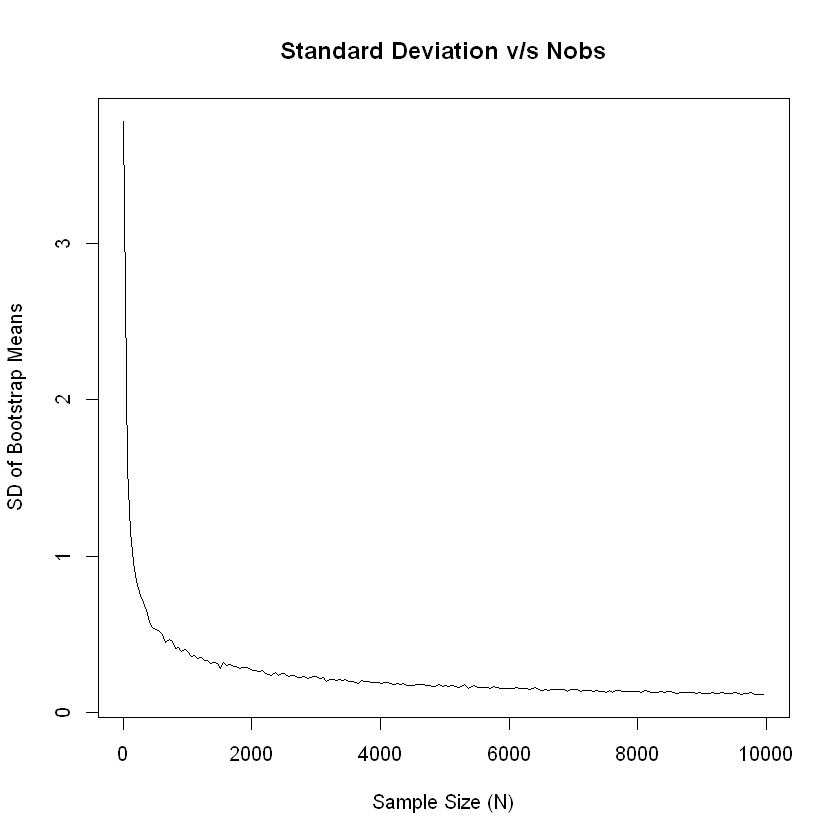

In [2]:
# the (sqrt)variance in the estimate of the mean -- nonparametric bootstrap
# the ground truth standard deviation of the normal distrubtion
# the standard deviation of the sample
# the (sqrt)variance in the estimate of the mean -- the textbook way, called "SEM"

set.seed(42)
max_size <- 10000
orig <- rnorm(max_size, 178.1, 12.1)

N_vals <- seq(10, 10000, by = 50)
std_devs <- numeric(length(N_vals))
B <- 500

# Loop over different sample sizes
for (i in seq_along(N_vals)) {
  N <- N_vals[i]
  bootstrap_means <- numeric(B)
  
  for (b in 1:B) {
    sample_data <- sample(orig, size = N, replace = TRUE)
    bootstrap_means[b] <- mean(sample_data)
  }
  
  std_devs[i] <- sd(bootstrap_means)
}

# Plot standard deviation of mean vs. sample size
par(bg="white")
plot(N_vals, std_devs, type = "l",
     xlab = "Sample Size (N)", ylab = "SD of Bootstrap Means",
     main = "Standard Deviation v/s Nobs")


## Question ii
In this simple case, according to standard textbooks, there is a formula for the uncertainty in the estimate of $\mu$, called the __standard error of the mean__, which is

$SEM = \hat{\sigma}/\sqrt{N_{\rm obs}}$.

Plot the standard deviation of $\hat{\mu}$ from non-parametric bootstrap versus $N_{\rm obs}$.

On the same axis, plot $\hat{\sigma}/\sqrt{N_{\rm obs}}$ versus $N_{\rm obs}$.

Do they agree?

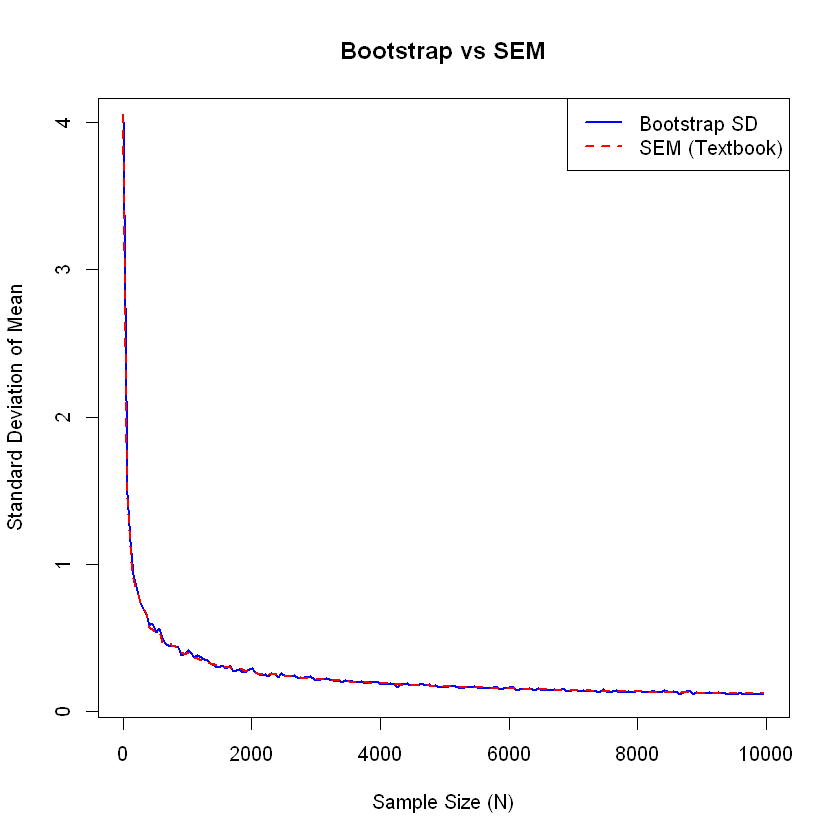

In [7]:
set.seed(42)

# Maximum size sample
max_size <- 10000
orig <- rnorm(max_size, 178.1, 12.1)

# Sampling parameters
N_vals <- seq(10, 10000, by = 50)
B <- 500  # bootstrap iterations

# Storage
std_devs_boot <- numeric(length(N_vals))
std_devs_sem <- numeric(length(N_vals))

# Loop over different sample sizes
for (i in seq_along(N_vals)) {
  N <- N_vals[i]
  
  # Subsample from original population
  sample_data <- sample(orig, size = N, replace = FALSE)
  
  # Sample SD (used in SEM formula)
  sample_sd <- sd(sample_data)
  std_devs_sem[i] <- sample_sd / sqrt(N)
  
  # Bootstrap sampling to estimate SD of sample mean
  bootstrap_means <- numeric(B)
  for (b in 1:B) {
    boot_sample <- sample(sample_data, size = N, replace = TRUE)
    bootstrap_means[b] <- mean(boot_sample)
  }
  std_devs_boot[i] <- sd(bootstrap_means)
}

# Plot both curves
par(bg = "white")
plot(N_vals, std_devs_boot, type = "l", col = "blue", lwd = 2,
     xlab = "Sample Size (N)", ylab = "Standard Deviation of Mean",
     main = "Bootstrap vs SEM")
lines(N_vals, std_devs_sem, col = "red", lwd = 2, lty = 2)
legend("topright", legend = c("Bootstrap SD", "SEM (Textbook)"),
       col = c("blue", "red"), lwd = 2, lty = c(1, 2))


# Part II: Cox proportional hazards model on breast cancer data


In [8]:
# Install required packages if not already installed
if (!requireNamespace("BiocManager", quietly = TRUE)) {
  install.packages("BiocManager")
}
if (!requireNamespace("curatedBreastData", quietly = TRUE)) {
  BiocManager::install("curatedBreastData")
}
if (!requireNamespace("survival", quietly = TRUE)) {
  install.packages("survival")
}
if (!requireNamespace("ggplot2", quietly = TRUE)) {
  install.packages("ggplot2")
}

In [9]:
# Load required libraries
library(curatedBreastData)
library(survival)
library(ggplot2)
library(dplyr)

Loading required package: XML

Loading required package: ggplot2

Loading required package: impute

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: 'generics'


The following objects are masked from 'package:base':

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, table, tapply, unique,
    unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain intr

To model an event that happens over time -- for example here, a death due to liver disease or breast cancer -- a powerful modeling framework is the Generalized Poisson Process, where the parameter is a function of time, and is called the hazard rate.
Furthermore, to predict how this depends on covariates, a commonly-used model is the Cox proportional Hazards Model.


## Question i

Learn about the Cox Proportional Hazards Model on wikipedia or elsewhere.
What is the likelihood function of the Cox Proportional Hazards Model?

The partial likelihood function of the Cox Proportional Hazards Model is:

$$L(\beta) = \prod_{j=1}^m \frac{\exp(\beta^T X_{(j)})}{\sum_{l \in R(t_j)} \exp(\beta^T X_l)}$$

where:

- $m$ is the number of observed events,
- $X_{(j)}$ is the covariate vector for the individual experiencing the event at time \(t_j\),
- $R(t_j)$ is the risk set just before time \(t_j\),
- $\beta$ is the coefficient vector.

The corresponding log-partial likelihood is:

$$\ell(\beta) = \sum_{j=1}^m \left( \beta^T X_{(j)} - \log \sum_{l \in R(t_j)} \exp(\beta^T X_l) \right)$$


## Question ii

Access the following public dataset on breast cancer survival:

In [13]:
# Load the curatedBreastData clinical data
data(clinicalData)

# Extract the clinical data table
clinical_df <- clinicalData$clinicalTable

# Explore survival data availability
cat("Total number of samples:", nrow(clinical_df), "\n")
cat("Samples with Overall Survival (OS) data:", sum(!is.na(clinical_df$OS)), "\n")
cat("Samples with OS months data:", sum(!is.na(clinical_df$OS_months_or_MIN_months_of_OS)), "\n")
cat("Samples with definitive follow-up until death:", sum(!is.na(clinical_df$OS_up_until_death)), "\n")

colnames(clinicalData$clinicalTable)


Total number of samples: 2719 
Samples with Overall Survival (OS) data: 409 
Samples with OS months data: 406 
Samples with definitive follow-up until death: 211 


[1] "dbUniquePatientID"                             
  [2] "study_ID"                                      
  [3] "patient_ID"                                    
  [4] "GEO_GSMID"                                     
  [5] "platform_ID"                                   
  [6] "GEO_platform_ID"                               
  [7] "AE_platform_ID"                                
  [8] "original_study_patient_ID"                     
  [9] "site_ID"                                       
 [10] "site_ID_preprocessed"                          
 [11] "biopsy_preTreat"                               
 [12] "biopsy_postTrt_days"                           
 [13] "pCR_postTrt_days"                              
 [14] "tumor_size_cm_preTrt_preSurgery"               
 [15] "tumor_size_cm_secondAxis_preTrt_preSurgery"    
 [16] "tumor_size_cm_preTrt_preSurgeryMin"            
 [17] "tumor_size_cm_postTrt"                         
 [18] "treatment_protocol_number"                     
 [19] "clinical_AJCC_stage"                           
 [20] "clinical_AJCC_stageRangeMin"                   
 [21] "clinical_AJCC_stageRangeMax"                   
 [22] "preTrt_lymph_node_status"                      
 [23] "postTrt_lymph_node_status"                     
 [24] "preTrt_totalLymphNodes"                        
 [25] "preTrt_numPosLymphNodes"                       
 [26] "preTrt_numPosLymphNodesRemoved"                
 [27] "postTrt_totalLymphNodes"                       
 [28] "postTrt_numPosLymphNodes"                      
 [29] "preTrt_posDichLymphNodes"                      
 [30] "notthingham_prognostic_index"                  
 [31] "tumor_stage_preTrt"                            
 [32] "tumor_stage_preTrtMin"                         
 [33] "tumor_stage_preTrtMax"                         
 [34] "tumor_stage_postTrt"                           
 [35] "pam50"                                         
 [36] "hist_grade"                                    
 [37] "hist_gradeMax"                                 
 [38] "hist_gradeMin"                                 
 [39] "nuclear_grade_preTrt"                          
 [40] "path_diagnosis"                                
 [41] "path"                                          
 [42] "chemosensitivity_prediction"                   
 [43] "pCR"                                           
 [44] "near_pCR"                                      
 [45] "pCR_spectrum"                                  
 [46] "RCB"                                           
 [47] "months_from_surgery_measured_RCB"              
 [48] "months_until_first_event_or_last_checkup"      
 [49] "RFS"                                           
 [50] "RFS_months_or_MIN_months_of_RFS"               
 [51] "DFS"                                           
 [52] "DFS_months_or_MIN_months_of_DFS"               
 [53] "OS"                                            
 [54] "OS_months_or_MIN_months_of_OS"                 
 [55] "OS_up_until_death"                             
 [56] "metastasis"                                    
 [57] "metastasis_months"                             
 [58] "relapseOneYearVsFivePlus"                      
 [59] "metastasis_stage_preTrt"                       
 [60] "dead"                                          
 [61] "died_from_cancer_if_dead"                      
 [62] "age"                                           
 [63] "age_bin_description"                           
 [64] "age_bin"                                       
 [65] "race"                                          
 [66] "nationality"                                   
 [67] "menopausal_status"                             
 [68] "ER_preTrt"                                     
 [69] "ER_percentage_preTrt"                          
 [70] "ER_expr_preTrt"                                
 [71] "ER_fmolmg_preTrt"                              
 [72] "ESR1_preTrt"                                   
 [73] "ERbb2_preTrt"                      

The following code restricts the data to a clean subset with only a few covariates for the purposes of this assignment.

In [14]:
# Create the dataset for analysis
surv_data <- clinical_df %>%
  select(
    OS,
    OS_months_or_MIN_months_of_OS,
    HER2_preTrt,
    age,
  ) %>%
  # Filter to only include complete cases for these key variables
  filter(
    !is.na(OS),
    !is.na(OS_months_or_MIN_months_of_OS),
    !is.na(HER2_preTrt),
    !is.na(age)
  )

# Check how many complete cases we have
cat("\nNumber of complete cases for Cox model:", nrow(surv_data), "\n")

# Convert categorical variables to factors
surv_data$HER2_preTrt <- factor(surv_data$HER2_preTrt)

# Display summary statistics
cat("\nSummary of our filtered dataset:\n")
print(summary(surv_data))


Number of complete cases for Cox model: 127 

Summary of our filtered dataset:
       OS        OS_months_or_MIN_months_of_OS HER2_preTrt      age       
 Min.   :0.000   Min.   :10.00                 0:84        Min.   :29.00  
 1st Qu.:1.000   1st Qu.:40.50                 1:43        1st Qu.:42.00  
 Median :1.000   Median :49.00                             Median :48.00  
 Mean   :0.811   Mean   :49.35                             Mean   :48.05  
 3rd Qu.:1.000   3rd Qu.:62.50                             3rd Qu.:53.00  
 Max.   :1.000   Max.   :87.00                             Max.   :65.00  


How many patients are there in the cleaned dataset?

In [16]:
cat("\nThe number of patients are:", nrow(surv_data), "\n")


The number of patients are: 127 


## Question iii

Use the R function to fit this data to the cox proportional hazards model on the full dataset. 
Plot the mean survival function (which is the complement of the cumulative distribution function of survival times).

Call:
coxph(formula = cox_formula, data = surv_data)

  n= 127, number of events= 103 

                 coef exp(coef) se(coef)     z Pr(>|z|)
HER2_preTrt1 0.275239  1.316845 0.216097 1.274    0.203
age          0.006778  1.006801 0.013181 0.514    0.607

             exp(coef) exp(-coef) lower .95 upper .95
HER2_preTrt1     1.317     0.7594    0.8622     2.011
age              1.007     0.9932    0.9811     1.033

Concordance= 0.521  (se = 0.032 )
Likelihood ratio test= 1.68  on 2 df,   p=0.4
Wald test            = 1.71  on 2 df,   p=0.4
Score (logrank) test = 1.72  on 2 df,   p=0.4



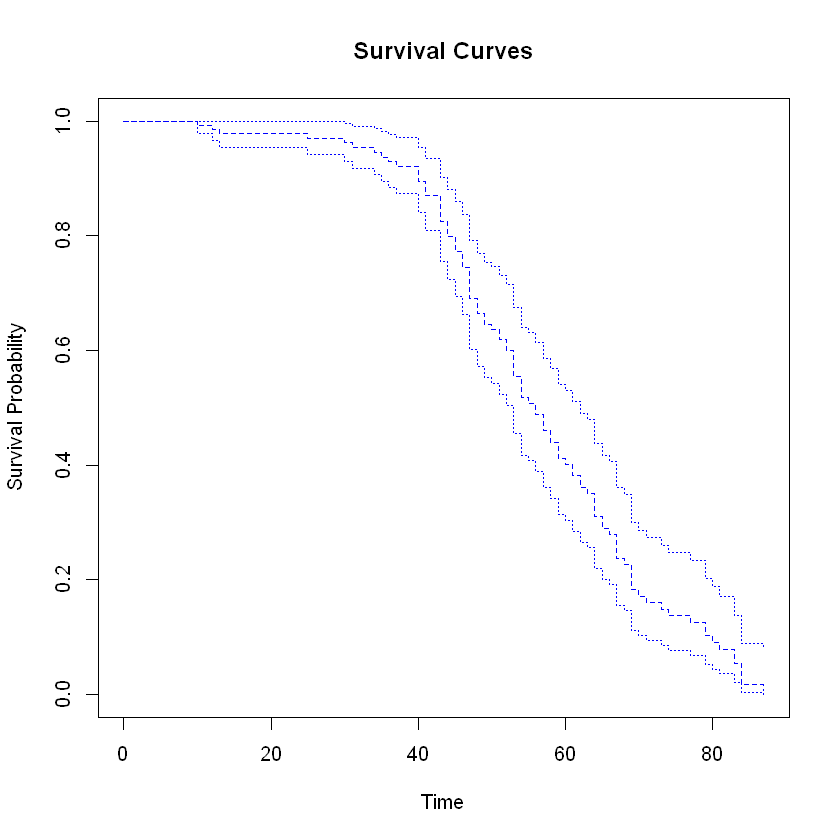

In [19]:
# Fit Cox Proportional Hazards model with the selected variables
cox_formula <- Surv(OS_months_or_MIN_months_of_OS, OS) ~ 
  HER2_preTrt + 
  age

# Initial model fit
initial_cox_model <- coxph(cox_formula, data = surv_data)
print(summary(initial_cox_model))

# Survival curve for average covariates (mean of training set)
sf_mean <- survfit(initial_cox_model)

par(bg = "white")
plot(sf_mean, col = "blue", lty = 2, xlab = "Time", ylab = "Survival Probability",
     main = "Survival Curves")

## Question iv

Suppose a new patient (called `fictitious_patient`) has the following information. 

In [20]:
fictitious_patient <- surv_data[1, , drop = FALSE]  # copy structure
fictitious_patient$HER2_preTrt <- factor("1", levels = levels(surv_data$HER2_preTrt))
fictitious_patient$age <- 45

According to the cox model you learned from the public dataset, what is their 3-year survival probability?

In [21]:
# Survival curve for the fictitious patient
sf_fict <- survfit(initial_cox_model, newdata = fictitious_patient)

three_years_in_months <- 3*12

# Find the closest time point to 3 years in the survival curve
closest_time_idx <- which.min(abs(sf_fict$time - three_years_in_months))
three_year_surv_prob <- sf_fict$surv[closest_time_idx]

cat("\n3-year survival probability for fictitious patient:", 
    round(three_year_surv_prob * 100, 1), "%\n")


3-year survival probability for fictitious patient: 91 %


## Question v

Perform a Bootstrap by repeating the cox learning algorithm, with `n_bootstrap = 200` resamplings of the patient data.
What is the standard deviation of the estimate of the 3-year survival probability? 
Note this is assuming you have data on `nrow(surv_data)` patients.

In [22]:
# Bootstrap with n_bootstrap = 200 and sample_size = nrow(surv_data)
n_bootstrap <- 200
three_years_in_months <- 3 * 12
bootstrap_surv_probs <- numeric(n_bootstrap)

set.seed(123)  # For reproducibility

for (b in 1:n_bootstrap) {
  # Sample patients with replacement
  boot_sample <- surv_data[sample(1:nrow(surv_data), replace = TRUE), ]
  
  # Fit Cox model on bootstrap sample
  boot_model <- coxph(Surv(OS_months_or_MIN_months_of_OS, OS) ~ HER2_preTrt + age, data = boot_sample)
  
  # Predict survival curve for fictitious patient
  sf_boot <- survfit(boot_model, newdata = fictitious_patient)
  
  # Find closest time to 3 years
  closest_time_idx <- which.min(abs(sf_boot$time - three_years_in_months))
  
  # Store the survival probability
  bootstrap_surv_probs[b] <- sf_boot$surv[closest_time_idx]
}

# Calculate the standard deviation of the 3-year survival probability estimates
std_dev_surv_prob <- sd(bootstrap_surv_probs)

cat("Standard deviation of 3-year survival probability estimate:", round(std_dev_surv_prob * 100, 2), "%\n")

Standard deviation of 3-year survival probability estimate: 3.08 %


## Question vi

Repeat the Bootstrap but for `sample_sizes <- 50:200`.
How many patient samples would be needed to estimate the Fictitious Patient's 3-year survival probability to within 5%?


Minimum sample size needed for 3-year survival probability estimate within 5% uncertainty is: 51 


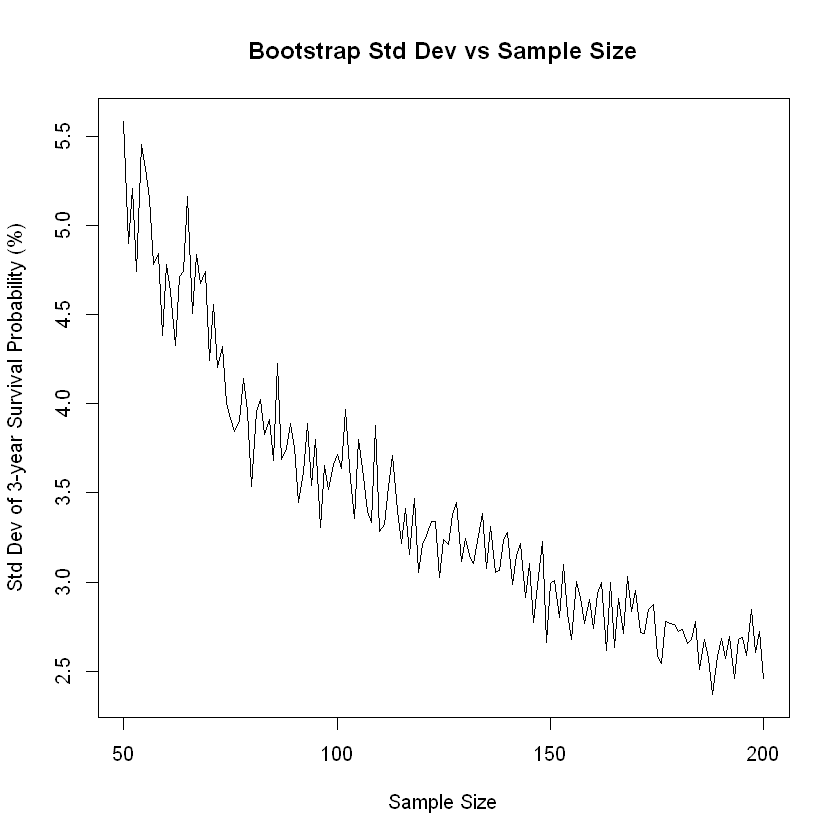

In [24]:
sample_sizes <- 50:200
n_bootstrap <- 200
three_years_in_months <- 3 * 12

# To store std deviations for each sample size
std_devs_by_size <- numeric(length(sample_sizes))

set.seed(123)

for (i in seq_along(sample_sizes)) {
  n <- sample_sizes[i]
  surv_probs <- numeric(n_bootstrap)
  
  for (b in 1:n_bootstrap) {
    # Bootstrap sample of size n from surv_data (with replacement)
    boot_sample <- surv_data[sample(1:nrow(surv_data), size = n, replace = TRUE), ]
    
    # Fit Cox model on bootstrap sample
    boot_model <- coxph(Surv(OS_months_or_MIN_months_of_OS, OS) ~ HER2_preTrt + age, data = boot_sample)
    
    # Predict survival for fictitious patient
    sf_boot <- survfit(boot_model, newdata = fictitious_patient)
    
    # Find closest time to 3 years in months
    closest_time_idx <- which.min(abs(sf_boot$time - three_years_in_months))
    
    surv_probs[b] <- sf_boot$surv[closest_time_idx]
  }
  
  # Store the standard deviation of survival probs for this sample size
  std_devs_by_size[i] <- sd(surv_probs)
  
  #cat("Sample size:", n, "- Std dev of 3-year survival prob:", round(std_devs_by_size[i]*100, 3), "%\n")
}

# Plotting standard deviation vs sample size
par(bg="white")
plot(sample_sizes, std_devs_by_size * 100, type = "l",
     xlab = "Sample Size", ylab = "Std Dev of 3-year Survival Probability (%)",
     main = "Bootstrap Std Dev vs Sample Size")

# Find minimum sample size for std dev < 5%
needed_sample_size <- sample_sizes[min(which(std_devs_by_size < 0.05))]
cat("\nMinimum sample size needed for 3-year survival probability estimate within 5% uncertainty is:", 
    needed_sample_size, "\n")
